# Import modules

In [1]:
import os, sys
os.getcwd()
if "../scripts/" not in sys.path:  # to prevent multyadding  
    sys.path.append("../scripts/") 

from IO import fetch_file, csv_filepath_to_dataframe, save_data_as_txt

from reducing import reduce_integers_and_floats, dataframe_footprint, convert_serie_to_unsigned_integer

from EDA import missing_values_analysis, plot_missing_values, plot_outliers, moving_averages, averaged_companies_over_time
from preprocessing import split_inliers_ouliers
from feature_engineering import filter_dataframe_outside_time_range, filter_serie_outside_time_range
from preprocessing import index_wth_formatted_date
from signaling import n_highest_per_row, average_n_past_values

# Fetch data
fetch stock_prices.csv and sp500.csv and save them in the data directory (../data/)

In [2]:
data_folder = "../data/"
results_folder = "../results/"

stock_prices_url = 'https://raw.githubusercontent.com/01-edu/public/master/subjects/ai/backtesting-sp500/data/stock_prices.csv'
stock_prices_filename = 'stock_prices.csv'
stock_prices_filepath = data_folder+stock_prices_filename

sp500_url = 'https://raw.githubusercontent.com/01-edu/public/master/subjects/ai/backtesting-sp500/data/sp500.csv'
sp500_filename = 'sp500.csv'
sp500_filepath = data_folder+sp500_filename

# fetch data from the net into data folder as csv file
fetch_file(
    folder = data_folder,
    filename = sp500_filename,
    url = sp500_url
)
fetch_file(
    folder = data_folder,
    filename = stock_prices_filename,
    url = stock_prices_url
)

# 1. Preliminary: load from csv files to pandas dataframes and optimize memory footprint
> For float data the smaller data type used is np.float32

function to check date format

In [3]:
def check_date_year_first(series):
    import pandas as pd
    str_stock_prices = series.astype(str).str[:4]
    try:
        years_stock_prices = pd.to_numeric(str_stock_prices,downcast='unsigned')
    except Exception as inst:
        print(inst)
    not_years_stock_prices = years_stock_prices[(years_stock_prices // 1000) <= 0]
    return not_years_stock_prices


## 1.1 stock prices

### read csv file

In [4]:
stock_prices_data_raw = csv_filepath_to_dataframe( stock_prices_filepath )
print(stock_prices_data_raw[['A','AA','AAPL', 'ACT','ZMH']].describe())

                 A           AA         AAPL          ACT          ZMH
count  3533.000000  3527.000000  3530.000000  3526.000000  3379.000000
mean     23.274053    19.813023    28.242043    58.185425    63.213848
std       8.105599     8.704232    30.022492    51.803983    18.878693
min       7.278983     4.920114     0.887419    18.620000    24.291195
25%      17.154249    11.182526     2.053170    29.030000    49.946464
50%      22.807468    19.784224    16.180510    36.595000    63.708561
75%      27.198820    27.171104    47.942927    61.950000    76.121148
max      45.324249    42.033146   119.000000   270.610000   114.828615


### index by date

In [5]:
print('Number of dates with not a years at the very begin: ', check_date_year_first(stock_prices_data_raw['Date']).size)
stock_prices_data_date_indexed = index_wth_formatted_date( stock_prices_data_raw )

Number of dates with not a years at the very begin:  0


### optimyze memory
it also removes the largest outliers

In [6]:
print("--before memory reducing--")
dataframe_footprint(stock_prices_data_raw)
stock_prices_data_reduced = reduce_integers_and_floats( stock_prices_data_date_indexed )
print("\n--after memory reducing--")
dataframe_footprint(stock_prices_data_reduced)
print('\n', stock_prices_data_reduced[['A','AA','AAPL', 'ACT','ZMH']].describe())
print('\n-- types--')
print(stock_prices_data_reduced.dtypes.head())
print('\nNnumber of collumns which type is not Float32: ', (stock_prices_data_reduced.dtypes!='Float32').sum()) 
# all collumns are Float32, we cant use smaller type, because it may reduce the precision of the data


--before memory reducing--
that many bytes : 15858820
that many kilobytes : 15487.12890625
that many megabytes : 15.124149322509766

--after memory reducing--
that many bytes : 9922612
that many kilobytes : 9690.05078125
that many megabytes : 9.462940216064453

                A         AA       AAPL         ACT         ZMH
count     3533.0     3527.0     3530.0      3526.0      3379.0
mean   23.274052  19.813021  28.242044   58.185432   63.213848
std     8.105598   8.704231  30.022493   51.803986   18.878695
min     7.278983   4.920114   0.887419   18.620001   24.291195
25%    17.154249  11.182526    2.05317   29.030001   49.946465
50%    22.807468  19.784224   16.18051   36.595001   63.708561
75%     27.19882  27.171104  47.942928   61.950001   76.121147
max    45.324249  42.033146      119.0  270.609985  114.828613

-- types--
A       Float32
AA      Float32
AAPL    Float32
ABBV    Float32
ABC     Float32
dtype: object

Nnumber of collumns which type is not Float32:  0


## 1.2 sp500

### read csv file

In [7]:
sp500_data_raw = csv_filepath_to_dataframe( sp500_filepath )
print(sp500_data_raw.describe())


              Open         High          Low        Close        Volume  \
count  3770.000000  3770.000000  3770.000000  3770.000000  3.770000e+03   
mean   1281.580164  1289.919486  1272.655725  1281.755169  2.914031e+09   
std     268.602896   268.140247   269.265603   268.828237  1.619203e+09   
min     679.280029   695.270020   666.789978   676.530029  3.560700e+08   
25%    1109.432526  1116.277527  1102.799988  1109.442535  1.450800e+09   
50%    1257.414978  1264.794983  1248.354981  1257.510010  2.742005e+09   
75%    1417.792481  1427.252502  1408.780029  1418.092468  3.930722e+09   
max    2084.300049  2092.699951  2084.300049  2088.770020  1.145623e+10   

       Adjusted Close  
count     3770.000000  
mean      1281.755169  
std        268.828237  
min        676.530029  
25%       1109.442535  
50%       1257.510010  
75%       1418.092468  
max       2088.770020  


### index by date

In [8]:
print('Number of dates with not a years at the very begin: ', check_date_year_first(sp500_data_raw['Date']).size)
sp500_data_date_indexed = index_wth_formatted_date( sp500_data_raw )

Number of dates with not a years at the very begin:  0


### optimyze memory

In [9]:
print("--before memory reducing--")
dataframe_footprint(sp500_data_raw)
sp500_data_reduced = reduce_integers_and_floats( sp500_data_date_indexed )
sp500_data_reduced['Volume'] = convert_serie_to_unsigned_integer(sp500_data_reduced['Volume'])

print("\n--after memory reducing--")
dataframe_footprint(sp500_data_reduced)
print('\n', sp500_data_reduced.describe())

print('\n-- types--')
print(sp500_data_reduced.dtypes)


--before memory reducing--
that many bytes : 211252
that many kilobytes : 206.30078125
that many megabytes : 0.20146560668945312
min, max 356070000.0 11456230000.0

--after memory reducing--
that many bytes : 158340
that many kilobytes : 154.62890625
that many megabytes : 0.15100479125976562

               Open         High          Low        Close             Volume  \
count       3770.0       3770.0       3770.0       3770.0             3770.0   
mean   1281.580078  1289.919556  1272.655762  1281.755127  2914030879.405836   
std     268.602905   268.140228   269.265594   268.828217  1619202889.881393   
min     679.280029    695.27002   666.789978   676.530029        356070016.0   
25%    1109.432526  1116.277527  1102.799988  1109.442535       1450800000.0   
50%    1257.414978  1264.794983   1248.35498   1257.51001       2742004992.0   
75%     1417.79248  1427.252502  1408.780029  1418.092468       3930722560.0   
max    2084.300049  2092.699951  2084.300049   2088.77002      11

# 2. Data wrangling and preprocessing
## Missing values analysis
make little stat on the missing values and save/show a plot about where missing valeus are located.

We saved plots to html files to keep them interactive.

Remove filepath from the functions call to plot graph in the notebook (beware it is big)
### stock prices
print number of missing values per ticket


In [10]:
print('Total number of columns: ',stock_prices_data_reduced.columns.size)
missing_values_analysis(stock_prices_data_reduced)
plot_missing_values(stock_prices_data_reduced,"../results/stock_prices_missing_values.png") # remove filepath to plot graph below (beware it is big)

Total number of columns:  543
columns with missing values:
Index(['A', 'AA', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACE', 'ACI', 'ACN', 'ACT',
       ...
       'XOM', 'XRAY', 'XRX', 'XYL', 'YHOO', 'YUM', 'ZION', 'ZLC', 'ZMH',
       'ZNGA'],
      dtype='object', length=543)

missing values information:
      missing_count  missing_percentage
A               111                3.05
AA              117                3.21
AAPL            114                3.13
ABBV           3137               86.09
ABC             120                3.29
...             ...                 ...
YUM             119                3.27
ZION            119                3.27
ZLC             262                7.19
ZMH             265                7.27
ZNGA           2890               79.31

[543 rows x 2 columns]

columns with >10% missing values information:
      missing_count  missing_percentage
ABBV           3137               86.09
ADT            3086               84.69
AIZ             905            

### sp500

In [11]:
missing_values_analysis(sp500_data_reduced)
plot_missing_values(sp500_data_reduced,"../results/sp500_missing_values.png")

columns with missing values:
Index([], dtype='object')

missing values information:
Empty DataFrame
Columns: [missing_count, missing_percentage]
Index: []

columns with >10% missing values information:
Empty DataFrame
Columns: [missing_count, missing_percentage]
Index: []


## Outliers analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


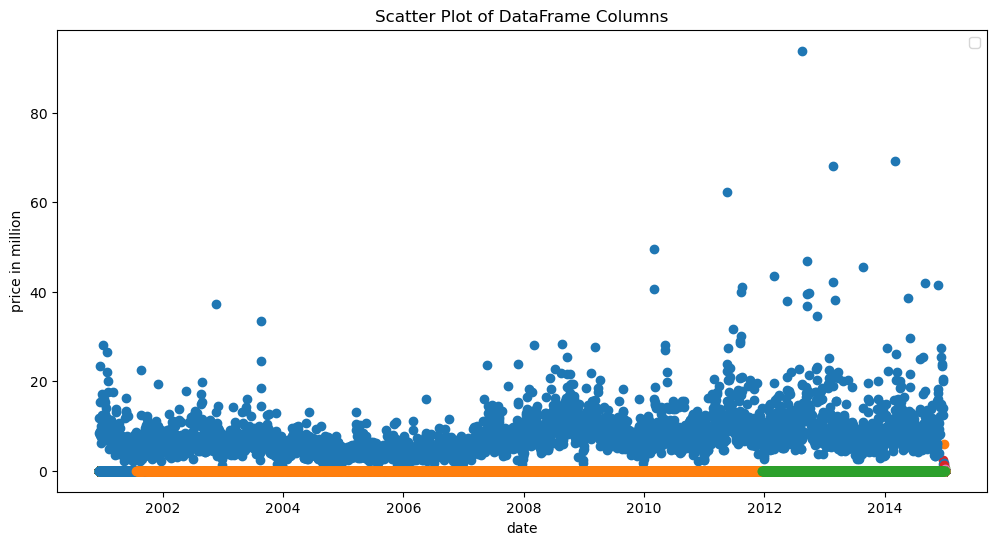

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
ig, ax = plt.subplots(figsize=(12, 6))
for col in stock_prices_data_reduced.columns:
    ax.scatter(stock_prices_data_reduced.index, stock_prices_data_reduced[col]/1_000_000)
ax.set_title('Scatter Plot of DataFrame Columns')
ax.set_xlabel('date')
ax.set_ylabel('price in million')
ax.legend()
plt.show()

In [13]:
plot_outliers(stock_prices_data_reduced, results_folder+"stock_prices_outliers.png")

#### average price for companies over time 

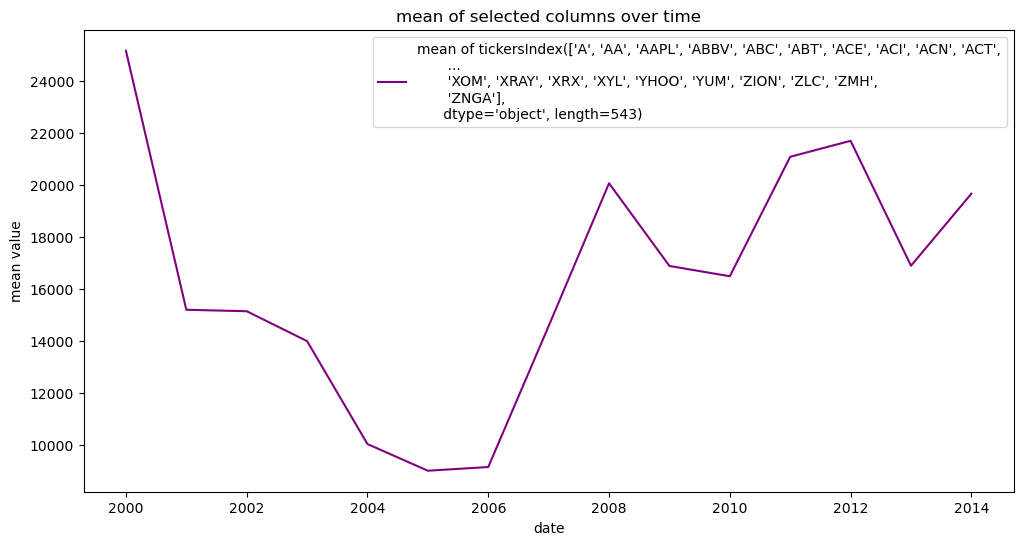

In [14]:
## if you want the average price of multiple companies over time

averaged_companies_over_time(stock_prices_data_reduced.groupby(stock_prices_data_reduced.index.year).mean(), stock_prices_data_reduced.columns,"../results/stock_prices_averaged.png")

print outliers in 2000

In [15]:
out2000_ix = stock_prices_data_reduced.groupby(stock_prices_data_reduced.index.year).mean().iloc[0].argmax()
print(stock_prices_data_reduced.iloc[:12,out2000_ix-1:out2000_ix+2 ])

                  SPG        SPLS    SRCL
Date                                     
2000-12-12  13.531988  11725800.0   8.875
2000-12-13  13.671839   8462100.0   9.015
2000-12-14  13.565553  15376600.0  8.9375
2000-12-15  13.565553  23464500.0  9.3125
2000-12-18  13.845255   7931200.0    9.25
2000-12-19  13.738968   8903700.0  9.4525
2000-12-20  13.531988  10049200.0  9.1875
2000-12-21  13.492829   7453800.0    8.89
2000-12-22  13.459266   6113400.0  8.7975
2000-12-26  13.358573   9224200.0  9.3275
2000-12-27   13.81169  17116300.0    9.78
2000-12-28  13.738968  12562500.0    9.75


### sp500

#### only volume

In [16]:
plot_outliers(sp500_data_reduced[['Volume']],"../results/sp500_volume_outliers.png")

#### 'Open','High','Low','Close' and 'Adjusted Close'

In [17]:
plot_outliers(sp500_data_reduced[['Open','High','Low','Close','Adjusted Close']],"../results/sp500_others_outliers.png")

## Describe at least 5 outliers 
('ticker', 'date', 'price'). Put them in outliers.txt file with the 3 fields on the folder results.


In [38]:
import pandas
stock_prices_data_inliers, stock_prices_data_outliers = split_inliers_ouliers(
    data=stock_prices_data_reduced, 
    min=0.1, 
    max=10_000
)

stock_prices_data_outliers= stock_prices_data_outliers.dropna(axis=1, how='all')
outliers_file = 'outliers.txt'
save_data_as_txt(f'outliers from stock prices\n', results_folder, outliers_file, 'wt')
i = 0
for index, row in stock_prices_data_outliers.iterrows():
    if i == 5:
        break
    for col in stock_prices_data_outliers.columns:
        if i == 5:
            break
        if row[col] is not pandas.NA :
            save_data_as_txt(
                f'ticker: {col}; price: {row[col]}; data: {index}\n', 
                results_folder, outliers_file, 
                'a'
            )
            print(f'ticker: {col}; price: {row[col]}; data: {index}\n')
            i += 1
            continue
    break

ticker: CSC; price: 0.0; data: 2000-12-12 00:00:00

ticker: DHR; price: 0.0; data: 2000-12-12 00:00:00

ticker: EMC; price: 0.0; data: 2000-12-12 00:00:00

ticker: KIM; price: 0.0; data: 2000-12-12 00:00:00

ticker: SPLS; price: 11725800.0; data: 2000-12-12 00:00:00



## Preprocess prices data 
### Resample data on month and keep the last value

#### stock prices

In [21]:
stock_prices_data_resampled = stock_prices_data_reduced.resample('BME').last()

#### sp500

In [22]:
sp500_data_resampled = sp500_data_reduced.resample('BME').last()

### Remove prices outside the range 0.1, 10k
#### stock prices

In [23]:
resampled_stock_prices_data_inliers, resampled_stock_prices_data_outliers = split_inliers_ouliers(stock_prices_data_resampled, 0.1, 10_000)

### Compute monthly returns : 
We compute what profit/loss 1$ on one ticker.

Historical returns:  Rh(t) = (P(t) - P(t-1))/P(t-1) = P(t)/P(t-1) - 1
Future returns: Rf(t) = (P(t+1)-P(t))/P(t) = P(t+1)/P(t) - 1
 let x=t+1 => Rf(x-1) = (P(x)-P(x-1)/P(x-1) = Rh(x) 
 so future returns = historical returns shifted by 1 day

#### stock prices



In [24]:
past_monthly_return_stock_prices_data = resampled_stock_prices_data_inliers.pct_change(fill_method=None)
print(past_monthly_return_stock_prices_data.iloc[:3,:5])

futur_monthly_return_stock_prices_data = past_monthly_return_stock_prices_data.shift(-1)
print(futur_monthly_return_stock_prices_data.iloc[:3,:5])

                   A        AA      AAPL  ABBV       ABC
Date                                                    
2000-12-29      <NA>      <NA>      <NA>  <NA>      <NA>
2001-01-31 -0.003653  0.101194  0.452957  <NA> -0.052871
2001-02-28 -0.340055 -0.026674 -0.155874  <NA>  0.123145
                   A        AA      AAPL  ABBV       ABC
Date                                                    
2000-12-29 -0.003653  0.101194  0.452957  <NA> -0.052871
2001-01-31 -0.340055 -0.026674 -0.155874  <NA>  0.123145
2001-02-28 -0.146389  0.005313  0.209315  <NA> -0.086932


#### sp500

In [25]:
sp500_data_resampled['monthly_past_return'] = sp500_data_resampled['Adjusted Close'].pct_change(fill_method=None)
#sp500_data_resampled['monthly_futur_return'] = -sp500_data_resampled['Adjusted Close'].pct_change(-1,fill_method=None)
sp500_data_resampled['monthly_futur_return'] = sp500_data_resampled['monthly_past_return'].shift(-1)
print(sp500_data_resampled.head(3))

                   Open         High          Low        Close      Volume  \
Date                                                                         
2000-01-31  1360.160034   1394.47998  1350.140015  1394.459961   993800000   
2000-02-29  1348.050049  1369.630005  1348.050049  1366.420044  1204300032   
2000-03-31  1487.920044  1519.810059  1484.380005  1498.579956  1227399936   

            Adjusted Close  monthly_past_return  monthly_futur_return  
Date                                                                   
2000-01-31     1394.459961                 <NA>             -0.020108  
2000-02-29     1366.420044            -0.020108               0.09672  
2000-03-31     1498.579956              0.09672             -0.030796  


### Remove monthly returns outliers outside of 2008 crisis 

#### stock prices

  make null any value outside of the 2008 and 2009 period and [-0.5, 1] range 

In [26]:
filtered_past_monthly_return_stock_prices_data = filter_dataframe_outside_time_range(
    dataframe = past_monthly_return_stock_prices_data,
    start_date = '2008-01-01',
    end_date = '2009-12-31',
    min_value = -0.5,
    max_value = 1,  
    # max_value = 10,  
)
filtered_futur_monthly_return_stock_prices_data = filter_dataframe_outside_time_range(
    dataframe = futur_monthly_return_stock_prices_data,
    start_date = '2008-01-01',
    end_date = '2009-12-31',
    min_value = -0.5,
    max_value = 1,  
    # max_value = 10,  
)

fill missing values by the last value available regarding the company 


In [27]:
filled_past_monthly_return_stock_prices_data = filtered_past_monthly_return_stock_prices_data.ffill()
filled_futur_monthly_return_stock_prices_data = filtered_futur_monthly_return_stock_prices_data.ffill()

import pandas as pd
print( pd.DataFrame({'Price': resampled_stock_prices_data_inliers.stack(),
 'past_monthly_return': filled_past_monthly_return_stock_prices_data.stack(),
 'futur_monthly_return':filled_futur_monthly_return_stock_prices_data.stack()}))

                     Price  past_monthly_return  futur_monthly_return
Date                                                                 
2000-12-29 A     36.730354                 <NA>             -0.003653
           AA    25.950483                 <NA>              0.101194
           AAPL   1.006463                 <NA>              0.452957
           ABC   11.438262                 <NA>             -0.052871
           ABT   38.794544                 <NA>              -0.07205
...                    ...                  ...                   ...
2014-12-31 YUM   73.279999            -0.051392             -0.051392
           ZION      28.67             0.021739              0.021739
           ZLC        <NA>            -0.017298             -0.017298
           ZMH      114.57             0.022272              0.022272
           ZNGA       2.72             0.046154              0.046154

[83954 rows x 3 columns]


#### sp500
make null any value outside of the 2008 and 2009 period and [-0.5, 1] range

In [28]:
sp500_data_resampled['monthly_past_return'] = filter_serie_outside_time_range(
    serie = sp500_data_resampled['monthly_past_return'],
    start_date = '2008-01-01',
    end_date = '2009-12-31',
    min_value = -0.5,
    max_value = 1,  
)
sp500_data_resampled['monthly_futur_return'] = filter_serie_outside_time_range(
    serie = sp500_data_resampled['monthly_futur_return'],
    start_date = '2008-01-01',
    end_date = '2009-12-31',
    min_value = -0.5,
    max_value = 1,  
)

fill missing values by the last value available regarding the company.

In [29]:
sp500_data_resampled['monthly_past_return'] = sp500_data_resampled['monthly_past_return'].ffill()

# we check that only first or last return (past/futur) are missing
sp500_data_resampled.isna().sum()

Open                    0
High                    0
Low                     0
Close                   0
Volume                  0
Adjusted Close          0
monthly_past_return     1
monthly_futur_return    1
dtype: int64

# 3. Create signal
## Average of monthly returns of the previous year
 get past year returns for each ticker for each month
 for stock prices only

In [30]:
past_year_averaged_monthly_return = average_n_past_values( filled_past_monthly_return_stock_prices_data, 12 )
#print(filled_past_monthly_return_stock_prices_data.iloc[:15,:3])
print(past_year_averaged_monthly_return.iloc[:5,:5])

                   A        AA      AAPL  ABBV       ABC
Date                                                    
2001-12-31 -0.036539  0.011402  0.051190   NaN  0.022666
2002-01-31 -0.030856  0.003673  0.024174   NaN  0.028620
2002-02-28 -0.000322  0.010283  0.026983   NaN  0.022190
2002-03-29  0.022070  0.010217  0.017105   NaN  0.030173
2002-04-30 -0.012088 -0.010608  0.006304   NaN  0.032988


## Define signal
20 selected ticker with the highest monthly average returns 
we should buy their stock each month


In [31]:
signal = n_highest_per_row(past_year_averaged_monthly_return,20)

# 4. Backtester
## Compute the PnL and the total return
### 20 selected strategy


In [32]:
top20_pnl = filled_futur_monthly_return_stock_prices_data[signal].mean(axis=1)
# what if we spend 20 $ each month on those 20 selected ticker ? (and cashed it out all every next month too)
# monthly PnL
top20_pnl_20_bucks_each_month = top20_pnl*20
print('-- PnL--')
print(top20_pnl_20_bucks_each_month[12:15]) # no strategy for first 12 months
print('-- total return --')
total20 = top20_pnl_20_bucks_each_month.sum()
print(total20)

-- PnL--
Date
2001-12-31    0.447674
2002-01-31    0.180102
2002-02-28    0.696765
Freq: BME, dtype: Float32
-- total return --
66.74962


###  investing 20$ each month on the SP500.

In [33]:
## pnl if we blindly just invested 20 $ in the SP500 ; (and cash it out all every month)
sp500_pnl = sp500_data_resampled['monthly_past_return']
sp500_pnl_20_bucks_each_month = sp500_pnl*20
print('-- PnL--')
print(sp500_pnl_20_bucks_each_month[12:15]) # no strategy for first 12 months
print('-- total return --')
total500 = sp500_pnl_20_bucks_each_month.sum()
print(total500)
# top20_pnl_20_bucks_each_month.plot()
# sp500_pnl_20_bucks_each_month.plot()

-- PnL--
Date
2001-01-31    0.692732
2001-02-28   -1.845815
2001-03-30   -1.284094
Freq: BME, Name: monthly_past_return, dtype: Float32
-- total return --
11.589245


## Compare 2 strategy

In [34]:
print('-- difference between 2 strategy (selected20 - sp500)--')
diff_strategy = total20 - total500
print(diff_strategy)

-- difference between 2 strategy (selected20 - sp500)--
55.160374


## Save the results in a text file results.txt

In [35]:
folder_results =  "../results/"
file_results ="results.txt"
destination_results = folder_results + file_results
if not os.path.exists(folder_results):
    os.makedirs(folder_results)
with open(destination_results, 'a') as file_destination:
    file_destination.write(f'total return of strategy "selected 20": {total20}\n')
    file_destination.write(f'total return of strategy "sp500": {total500}\n')
    file_destination.write(f'difference between 2 strategy (selected20 - sp500): {diff_strategy}\n')
        

## Create a plot that shows the performance of the strategy over time 
A data point (x-axis: date, y-axis: cumulated_return) is: the cumulated returns from the beginning of the strategy at date t. 

Save the plot in the results folder.

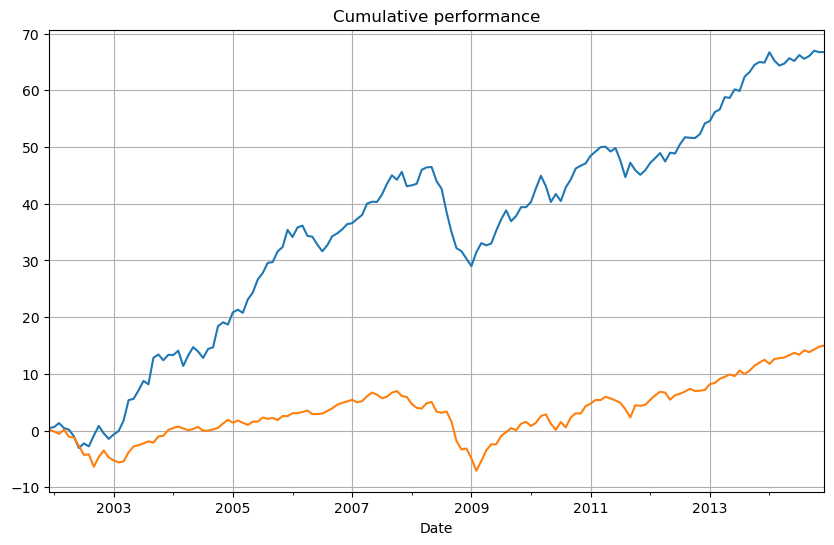

In [36]:
# drop na - first 12 motnth dont have a strategy
#top20_cumulated_return = ((top20_pnl.dropna()*20).cumsum())
#sp500_cumulated_return = (sp500_pnl.loc[sp500_pnl.index>='2001-12-31']*20).cumsum() 
import matplotlib.pyplot as plt
top20_cumulated_return = ((top20_pnl_20_bucks_each_month.dropna()).cumsum())
sp500_cumulated_return = (sp500_pnl_20_bucks_each_month.loc[sp500_pnl_20_bucks_each_month.index>='2001-12-31']).cumsum() 

top20_cumulated_return.plot(figsize = (10,6), grid = True, title = 'Cumulative performance')
sp500_cumulated_return.plot( grid = True)
plt.savefig(folder_results+"cumulative_performance.png")